In [9]:
import xarray as xr
import matplotlib.pyplot as plt
import xwrf
import xgcm
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import cmweather
import act
from pyproj import Transformer, CRS
from metpy.calc import wind_speed
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [2]:
wrf_ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/WFIP3_LES/*',
                           concat_dim='Time', combine='nested').xwrf.postprocess()

In [3]:
wrf_ds

<xarray.Dataset> Size: 25GB
Dimensions:                    (Time: 37, y: 420, x: 375, z: 50, x_stag: 376,
                                y_stag: 421, z_stag: 51, soil_layers_stag: 4,
                                seed_dim_stag: 8)
Coordinates: (12/15)
    CLAT                       (y, x) float32 630kB dask.array<chunksize=(420, 375), meta=np.ndarray>
    XLAT                       (y, x) float32 630kB dask.array<chunksize=(420, 375), meta=np.ndarray>
    XLONG                      (y, x) float32 630kB dask.array<chunksize=(420, 375), meta=np.ndarray>
    XTIME                      (Time) datetime64[ns] 296B dask.array<chunksize=(1,), meta=np.ndarray>
    XLAT_U                     (y, x_stag) float32 632kB dask.array<chunksize=(420, 376), meta=np.ndarray>
    XLONG_U                    (y, x_stag) float32 632kB dask.array<chunksize=(420, 376), meta=np.ndarray>
    ...                         ...
  * z_stag                     (z_stag) float32 204B 1.0 0.9987 ... 0.09159 0.0
  * Time                       (Time) datetime64[ns] 296B 2024-03-24T17:00:00...
  * x                          (x) float64 3kB -1.496e+04 ... 1.496e+04
  * y_stag                     (y_stag) float64 3kB 3.835e+06 ... 3.869e+06
  * x_stag                     (x_stag) float64 3kB -1.5e+04 ... 1.5e+04
  * y                          (y) float64 3kB 3.835e+06 3.835e+06 ... 3.869e+06
Dimensions without coordinates: soil_layers_stag, seed_dim_stag
Data variables: (12/145)
    Times                      (Time) |S19 703B dask.array<chunksize=(1,), meta=np.ndarray>
    LU_INDEX                   (Time, y, x) float32 23MB dask.array<chunksize=(1, 420, 375), meta=np.ndarray>
    VAR_SSO                    (Time, y, x) float32 23MB dask.array<chunksize=(1, 420, 375), meta=np.ndarray>
    BATHYMETRY_FLAG            (Time) int32 148B dask.array<chunksize=(1,), meta=np.ndarray>
    U                          (Time, z, y, x_stag) float32 1GB dask.array<chunksize=(1, 50, 420, 376), meta=np.ndarray>
    V                          (Time, z, y_stag, x) float32 1GB dask.array<chunksize=(1, 50, 421, 375), meta=np.ndarray>
    ...                         ...
    SST_INPUT                  (Time, y, x) float32 23MB dask.array<chunksize=(1, 420, 375), meta=np.ndarray>
    air_potential_temperature  (Time, z, y, x) float32 1GB dask.array<chunksize=(1, 50, 420, 375), meta=np.ndarray>
    air_pressure               (Time, z, y, x) float32 1GB dask.array<chunksize=(1, 50, 420, 375), meta=np.ndarray>
    geopotential               (Time, z_stag, y, x) float32 1GB dask.array<chunksize=(1, 51, 420, 375), meta=np.ndarray>
    geopotential_height        (Time, z_stag, y, x) float32 1GB dask.array<chunksize=(1, 51, 420, 375), meta=np.ndarray>
    wrf_projection             object 8B +proj=merc +x_0=0 +y_0=0 +a=6370000 ...
Attributes: (12/134)
    TITLE:                            OUTPUT FROM WRF V4.5.1 MODEL
    START_DATE:                      2024-03-24_17:00:00
    SIMULATION_START_DATE:           2024-03-24_17:00:00
    WEST-EAST_GRID_DIMENSION:        376
    SOUTH-NORTH_GRID_DIMENSION:      421
    BOTTOM-TOP_GRID_DIMENSION:       51
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [8]:
U = wrf_ds.U.metpy.quantify().xwrf.destagger()
V = wrf_ds.V.metpy.quantify().xwrf.destagger()
W = wrf_ds.W.metpy.quantify().xwrf.destagger()
for time_i in range(0, 37):
    fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.PlateCarree()))
    W.metpy.dequantify().isel(Time=time_i, z=6).plot(x='XLONG', y='XLAT', ax=ax, cmap='balance', vmin=-2, vmax=2)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax.streamplot(U["XLONG"], U["XLAT"],
          U.isel(Time=time_i, z=6), V.isel(Time=time_i, z=6))
    wrf_ds['HGT'].isel(Time=time_i).plot.contour(x='XLONG', y='XLAT', color='k')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.text(-70.05343611, 42.03246111, 'X', fontsize=20)
    #gl.xlabel_style = {'size': 15, 'color': 'gray'}
    #gl.xlabel_style = {'color': 'red', 'weight': 'bold'}
    ax.coastlines(resolution='10m')
    fig.tight_layout()
    fig.savefig('Model_W%d.png' % time_i)
    plt.close(fig)

/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'color'
  result = super().contour(*args, **kwargs)
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'color'
  result = super().conto

In [12]:
def sample_wrf_ds_at_latlon(ds, lat, long):
    trf = Transformer.from_crs(CRS.from_epsg(4326), ds.wrf_projection.item(), always_xy=True)
    x, y = trf.transform(long, lat)
    return ds.interp(x=x, y=y, x_stag=x, y_stag=y)


In [13]:
lidar_column = sample_wrf_ds_at_latlon(wrf_ds, 42.03246111, -70.05343611)

In [141]:
lidar_column['geopotential_height'].values[0:10]

array([[   27.09795261,    36.72759491,    46.36137538,    55.99872437,
           65.63989299,    75.2845337 ,    85.8986991 ,    97.58590902,
          110.45471588,   124.62878114,   140.24213676,   157.44512064,
          176.40478059,   197.3068621 ,   220.34848057,   245.75444328,
          273.77424659,   304.68598461,   338.7993125 ,   376.45842449,
          418.04675704,   463.99636416,   514.79423345,   570.99592578,
          633.23587409,   702.26292385,   778.92137035,   864.19025441,
          959.19153473,  1065.21802299,  1183.72165017,  1316.41595303,
         1465.33027608,  1632.92521863,  1822.17222966,  2036.56825497,
         2280.05380813,  2556.87267068,  2872.13918253,  3231.46148357,
         3642.75647872,  4115.99442127,  4664.03762586,  5303.12595252,
         6055.81827476,  6955.98648686,  8057.52431637,  9463.91950434,
        11342.23663142, 14173.62599083, 20467.6806383 ],
       [   27.09795261,    36.77362419,    46.4396588 ,    56.09817268,
       

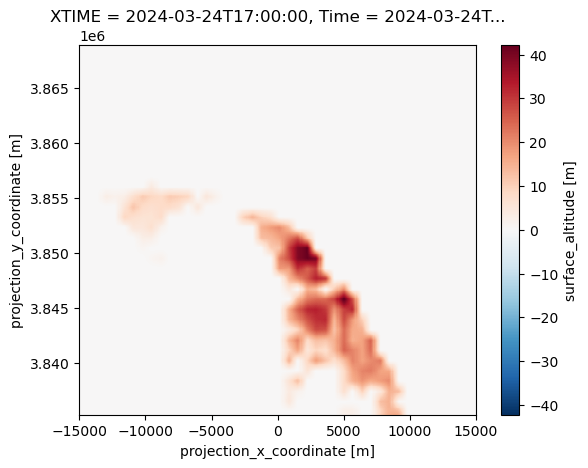

In [183]:
wrf_ds['HGT'].isel(Time=0).plot()

In [16]:
grid = xgcm.Grid(lidar_column, periodic=False)
geopotential_height = lidar_column['geopotential_height'].xwrf.destagger().metpy.dequantify()
target_levels = np.arange(0, 1500, 30.)
W_col = grid.transform(lidar_column.W.xwrf.destagger().metpy.dequantify(), 'Z', target_levels, target_data=geopotential_height)
W_col = W_col.compute()
U_col = grid.transform(lidar_column.U.metpy.dequantify(), 'Z', target_levels, target_data=geopotential_height)
U_col = U_col.compute()
V_col = grid.transform(lidar_column.V.metpy.dequantify(), 'Z', target_levels, target_data=geopotential_height)
V_col = V_col.compute()

/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/xgcm/grid.py:1026: UserWarning: Input`target_data` has no name, but we need a name for the transformed dimension. The name `TRANSFORMED_DIMENSION` will be used. To avoid this warning, call `.rename` on `target_data` before calling `transform`.
  warnings.warn(
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_

In [139]:
grid = xgcm.Grid(lidar_column, periodic=False)
geopotential_height = lidar_column['geopotential_height'].metpy.dequantify()
target_levels = np.arange(0, 1500, 30.)
TKE = grid.transform(lidar_column.TKE_PBL.metpy.dequantify(), 'Z', target_levels, target_data=geopotential_height)
TKE = TKE.compute()

/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(


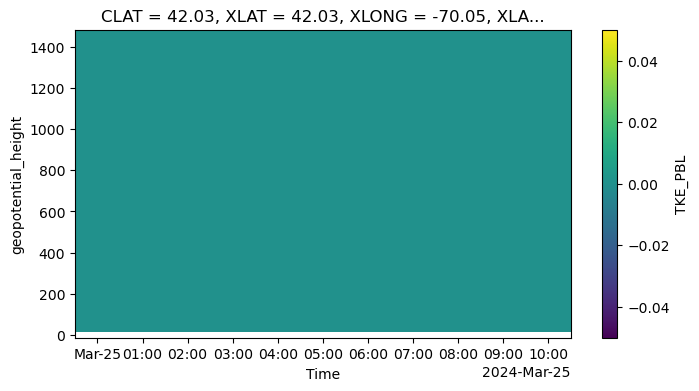

In [140]:
plt.figure(figsize=(8, 4))
TKE.T.sel(Time=slice('2024-03-25T00:00:00', '2024-03-25T10:00:00')).plot()

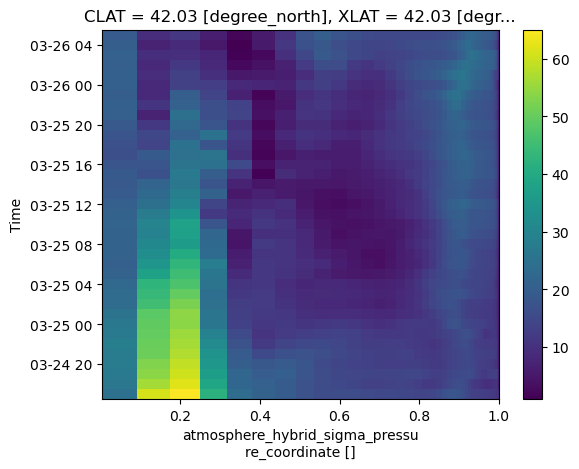

In [153]:
spd = np.sqrt((lidar_column['U']**2 + lidar_column['V']**2))
spd.plot()

In [177]:
spd = wind_speed(lidar_column.U.metpy.quantify(), 
                        lidar_column.V.metpy.quantify()).metpy.dequantify()
grid = xgcm.Grid(lidar_column, periodic=False)
geopotential_height = lidar_column['geopotential_height'].xwrf.destagger().metpy.dequantify()
target_levels = np.arange(0, 1500, 30.)
spd = grid.transform(spd, 'Z', target_levels, target_data=geopotential_height)
spd = spd.compute()

/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/xgcm/grid.py:989: FutureWarning: From version 0.8.0 the Axis computation methods will be removed, in favour of using the Grid computation methods instead. i.e. use `Grid.transform` instead of `Axis.transform`
  warnings.warn(
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/xgcm/grid.py:1026: UserWarning: Input`target_data` has no name, but we need a name for the transformed dimension. The name `TRANSFORMED_DIMENSION` will be used. To avoid this warning, call `.rename` on `target_data` before calling `transform`.
  warnings.warn(


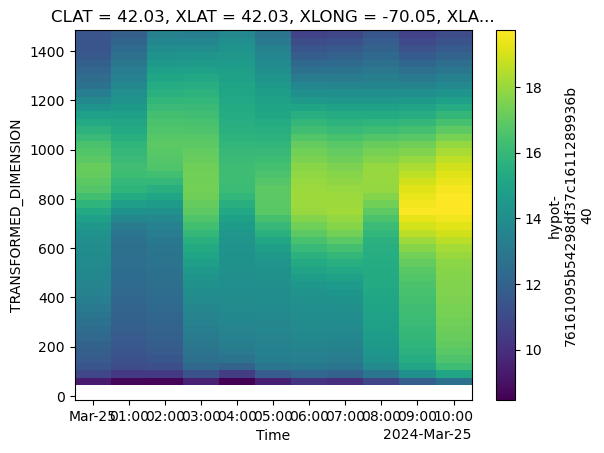

In [180]:
spd.sel(Time=slice('2024-03-25T00:00:00', '2024-03-25T10:00:00')).T.plot()

/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/gpfs/fs1/home/rjackson/mambaforge/envs/crocus_env/lib/python3.11/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


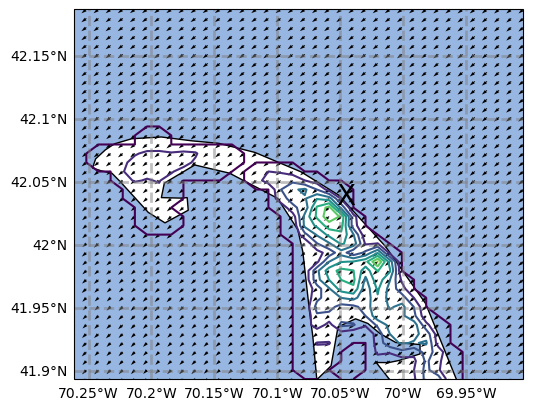

In [84]:
U = wrf_ds.U.metpy.quantify().xwrf.destagger()
V = wrf_ds.V.metpy.quantify().xwrf.destagger()
W = wrf_ds.W.metpy.quantify().xwrf.destagger()
fig, ax = plt.subplots(1, 1, subplot_kw=(dict(projection=ccrs.PlateCarree())))
ax.quiver(U["XLONG"][::10, ::10], U["XLAT"][::10, ::10],
          U.isel(Time=16, z=6)[::10, ::10], V.isel(Time=16, z=6)[::10, ::10])
ax.contour(U["XLONG"][::10, ::10], U["XLAT"][::10, ::10],
          wrf_ds["HGT"].isel(Time=16)[::10, ::10])
ax.text(-70.05343611, 42.03246111, 'X', fontsize=20)
ax.coastlines(resolution='10m')
ax.add_feature(cfeature.OCEAN)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

In [52]:
wrf_ds['TKE'].max().values

array(0., dtype=float32)

In [174]:
lidar_ds = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/lidar_ingested/20240325/dl.wfip3.caco.20240325.*0000.r0.nc')

Text(0, 0.5, 'Height [m]')

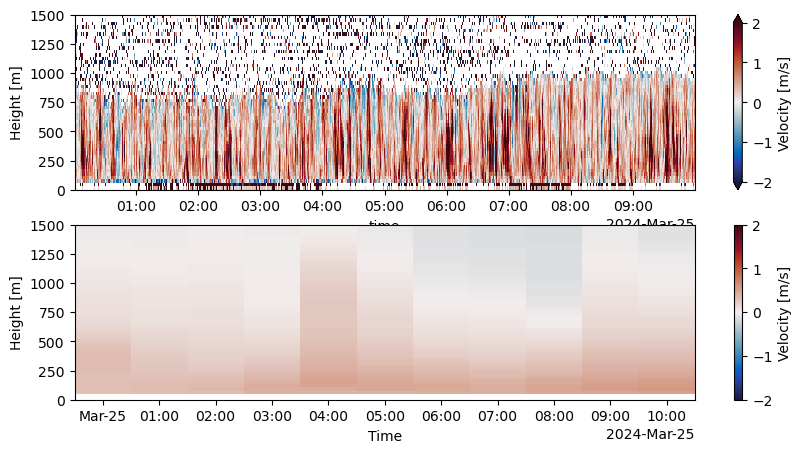

In [181]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
mask = lidar_ds['intensity'] > 1.008
lidar_ds['radial_velocity'].where(mask).sel(time=slice('2024-03-25T00:00:00', '2024-03-25T10:00:00')).T.plot(
    vmin=-2, vmax=2, cmap='balance', ax=ax[0], cbar_kwargs=dict(label="Velocity [m/s]"))
W.metpy.dequantify().T.sel(Time=slice('2024-03-25T00:00:00', '2024-03-25T10:00:00')).plot(
    ax=ax[1],cbar_kwargs=dict(label="Velocity [m/s]"), vmin=-2, vmax=2, cmap='balance')
ax[0].set_ylim([0, 1500])
ax[1].set_ylim([0, 1500])
ax[1].set_title('')
ax[1].set_ylabel('Height [m]')
ax[0].set_ylabel('Height [m]')

Text(0, 0.5, 'Height [m]')

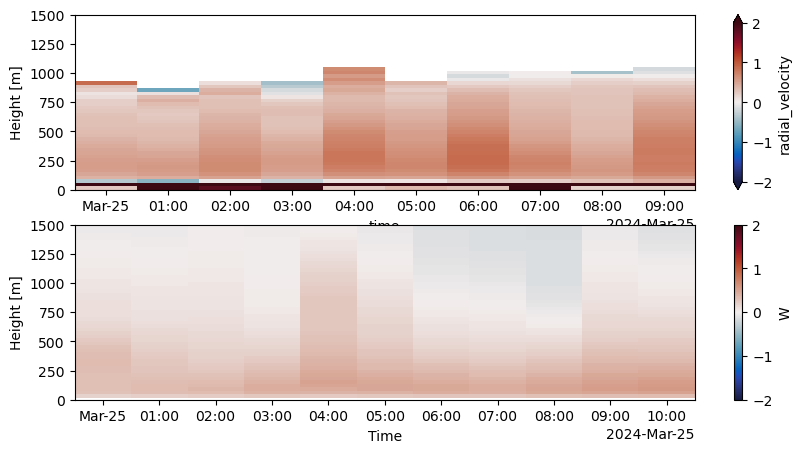

In [127]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
mask = lidar_ds['intensity'] > 1.03
lidar_ds['radial_velocity'].where(mask).sel(time=slice('2024-03-25T00:00:00', '2024-03-25T10:00:00')).resample(time='1h').mean().T.plot(
    vmin=-2, vmax=2, cmap='balance', ax=ax[0])
W.T.sel(Time=slice('2024-03-25T00:00:00', '2024-03-25T10:00:00')).plot(ax=ax[1], vmin=-2, vmax=2, cmap='balance')
ax[0].set_ylim([0, 1500])
ax[1].set_ylim([0, 1500])
ax[1].set_title('')
ax[1].set_ylabel('Height [m]')
ax[0].set_ylabel('Height [m]')

In [66]:
lidar_ds

<xarray.Dataset> Size: 2GB
Dimensions:          (time: 136675, range: 400)
Coordinates:
  * range            (range) float64 3kB 15.0 45.0 75.0 ... 1.196e+04 1.198e+04
  * time             (time) datetime64[ns] 1MB 2024-03-25T00:00:43.279992 ......
    azimuth          (time) float64 1MB dask.array<chunksize=(5729,), meta=np.ndarray>
    elevation        (time) float64 1MB dask.array<chunksize=(5729,), meta=np.ndarray>
    pitch            (time) float64 1MB dask.array<chunksize=(5729,), meta=np.ndarray>
    roll             (time) float64 1MB dask.array<chunksize=(5729,), meta=np.ndarray>
Data variables:
    radial_velocity  (time, range) float64 437MB dask.array<chunksize=(5729, 400), meta=np.ndarray>
    beta             (time, range) float64 437MB dask.array<chunksize=(5729, 400), meta=np.ndarray>
    intensity        (time, range) float64 437MB dask.array<chunksize=(5729, 400), meta=np.ndarray>
    spectral_width   (time, range) float64 437MB dask.array<chunksize=(5729, 400), meta=np.ndarray>
    latitude         (time) float64 1MB 42.03 42.03 42.03 ... 42.03 42.03 42.03
    longitude        (time) float64 1MB -70.05 -70.05 -70.05 ... -70.05 -70.05
    altitude         (time) float64 1MB 51.4 51.4 51.4 51.4 ... 51.4 51.4 51.4
Attributes:
    Conventions:         CF-1.7
    version:             R0
    mentor:              Bobby Jackson
    mentor_email:        rjackson@anl.gov
    mentor_institution:  Argonne National Laboratory
    mentor_orcid:        0000-0003-2518-1234
    contributors:        Bobby Jackson, Scott Collis, Paytsar Muradyan, Max G...
    scan_type:           fpt

In [71]:
lidar_ds["longitude"]

<xarray.DataArray 'longitude' (time: 136675)> Size: 1MB
array([-70.05343611, -70.05343611, -70.05343611, ..., -70.05343611,
       -70.05343611, -70.05343611])
Coordinates:
  * time       (time) datetime64[ns] 1MB 2024-03-25T00:00:43.279992 ... 2024-...
    azimuth    (time) float64 1MB dask.array<chunksize=(5729,), meta=np.ndarray>
    elevation  (time) float64 1MB dask.array<chunksize=(5729,), meta=np.ndarray>
    pitch      (time) float64 1MB dask.array<chunksize=(5729,), meta=np.ndarray>
    roll       (time) float64 1MB dask.array<chunksize=(5729,), meta=np.ndarray>
Attributes:
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [58]:
vads = xr.open_mfdataset('/lcrc/group/earthscience/rjackson/wfip3/caco/vad/caco.lidar.vad.20240325.nc')
vads["wind_speed"] = vads["wind_speed"].where(vads["signal_to_noise_ratio"] > 0.01)
vads["u"] = -np.sin(np.deg2rad(vads["wind_direction"])) * vads["wind_speed"]
vads["v"] = -np.cos(np.deg2rad(vads["wind_direction"])) * vads["wind_speed"]


In [41]:
winds_wrf = xr.Dataset({'u': U_col, 'v': V_col, 'w': W_col})
winds_wrf["dir"] = np.arctan2(-winds_wrf['u'],-winds_wrf['v'])
winds_wrf["spd"] = np.sqrt(winds_wrf['u']**2 + winds_wrf['v']**2)

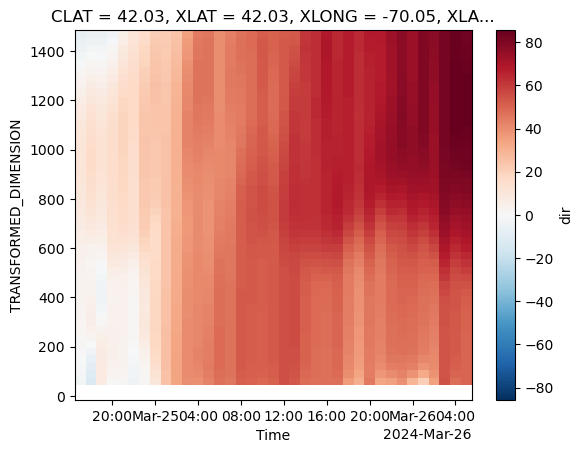

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
np.rad2deg(winds_wrf["dir"].T).plot()

In [57]:
vads

<xarray.Dataset> Size: 14MB
Dimensions:                (time: 498, height: 400)
Coordinates:
  * time                   (time) datetime64[ns] 4kB 2024-03-25T00:00:27.9900...
  * height                 (height) float64 3kB 12.99 38.97 ... 1.038e+04
Data variables:
    wind_speed             (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>
    wind_direction         (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>
    wind_speed_error       (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>
    wind_direction_error   (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>
    signal_to_noise_ratio  (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>
    residual               (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>
    correlation            (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>
    u                      (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>
    v                      (time, height) float64 2MB dask.array<chunksize=(498, 400), meta=np.ndarray>

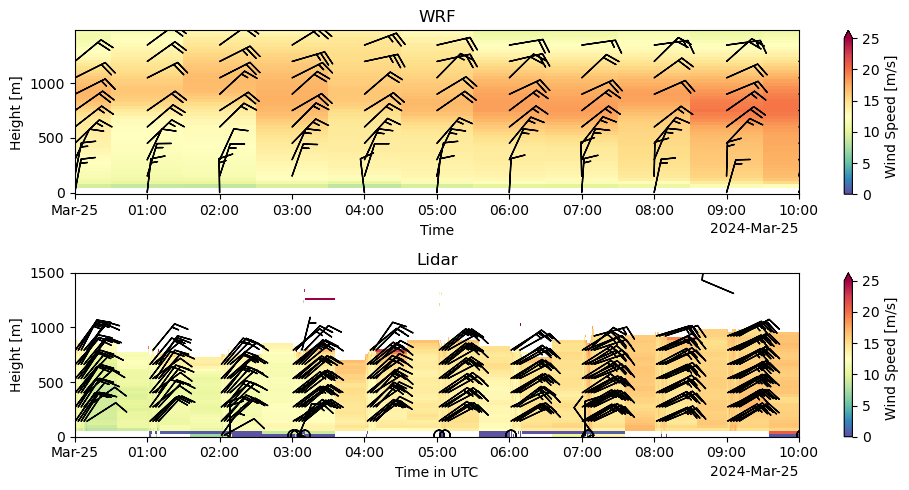

In [68]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
winds_wrf["spd"].T.plot(ax=ax[0], cbar_kwargs=dict(label="Wind Speed [m/s]"), vmin=0, vmax=25, cmap='Spectral_r')
x, y = np.meshgrid(winds_wrf["XTIME"], winds_wrf["TRANSFORMED_DIMENSION"][::5])
ax[0].barbs(x, y, winds_wrf["u"][::, ::5], winds_wrf["v"][::, ::5])
ax[0].set_title('WRF')
x, y = np.meshgrid(vads["time"], vads["height"], indexing='ij')
vads["wind_speed"].T.plot(ax=ax[1], cbar_kwargs=dict(label="Wind Speed [m/s]"), 
                          vmin=0, vmax=25, cmap='Spectral_r')
ax[1].barbs(x[::5, ::5], y[::5, ::5], vads["u"][::5, ::5], vads["v"][::5, ::5])
ax[1].set_title('Lidar')
ax[0].set_ylabel("Height [m]")
ax[1].set_ylabel("Height [m]")
ax[0].set_xlim([np.datetime64('2024-03-25T00:00:00'), np.datetime64('2024-03-25T10:00:00')])
ax[1].set_xlim([np.datetime64('2024-03-25T00:00:00'), np.datetime64('2024-03-25T10:00:00')])
ax[1].set_ylim([0, 1500])
fig.tight_layout()